In [3]:
import pandas as pd
import random
import numpy as np
from statsmodels.formula.api import logit
from plotnine import *
import sklearn.ensemble
import sklearn.model_selection
import sklearn.metrics
import sklearn.linear_model
import matplotlib.pylab as plt
from clean_data import *

In [4]:
#Reading the data in
df = pd.read_csv("data/loan_level_500k.csv", low_memory=False, index_col=19)

In [5]:
#Tidying data with script
df = tidy_data(df)

In [6]:
#Sampling our data for our Logistic Regression due to computational constraints
df = df.sample(10000)

In [7]:
#Function from Project 4 with slight modification to return the actual model aswell
def get_roc_data(model, cv_obj):
    curve_df = None
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    
    for i, (train, test) in enumerate(cv_obj.split(X, y)):
        model.fit(X[train], y[train])
        scores = model.predict_proba(X[test])[:,1]
        fpr, tpr, _ = sklearn.metrics.roc_curve(y[test],scores)
        
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tmp = pd.DataFrame({'fold':i, 'fpr': mean_fpr, 'tpr': interp_tpr})
        curve_df = tmp if curve_df is None else pd.concat([curve_df, tmp])
        
        aucs.append(sklearn.metrics.auc(fpr, tpr))
        
    curve_df = curve_df.groupby('fpr').agg({'tpr': 'mean'}).reset_index()
    curve_df.iloc[-1,1] = 1.0
    
    auc_df = pd.DataFrame({'fold': np.arange(len(aucs)), 'auc': aucs})
    return curve_df, auc_df, model

In [8]:
#Logistic Regression Prep
cv_obj = sklearn.model_selection.StratifiedKFold(n_splits=10)

lr = sklearn.linear_model.LogisticRegression(n_jobs = -1)
parameters = {}

lr_cv = sklearn.model_selection.GridSearchCV(lr, parameters, cv=10)

In [9]:
#Using Function from clean_data script to split into testing and training data
train,test, _ = get_train_test_split_for_ml(df, 2000,pre_process=True )

In [10]:
#Removing attributes
X = train.drop(["DELINQUENT","PREPAID"],axis=1).to_numpy()
y = train["DELINQUENT"]

In [11]:
#Using Function From Project 4 to train the logistic regression model
lr_curve_df, lr_auc_df, trained_model = get_roc_data(lr_cv, cv_obj)

lr_curve_df['model'] = 'logistic regression'
lr_auc_df['model'] = 'logistic regression'

In [12]:
#Generating the Confusion Matrix using our test data
from sklearn.metrics import confusion_matrix

X = test.drop(["DELINQUENT","PREPAID"],axis=1).to_numpy()
y = test["DELINQUENT"]

scores = trained_model.predict_proba(X)[:,1]
scores = [1 if i > 0.5 else 0 for i in scores]

cm = confusion_matrix(y, scores)
print ("Confusion Matrix : \n", cm)

Confusion Matrix : 
 [[4632    9]
 [ 192    0]]


In [13]:
#Printing out each value from the Confusion Matrix
tn, fp, fn, tp = cm.ravel()
(tn, fp, fn, tp)

(4632, 9, 192, 0)

In [19]:
#Evaluation of Confusion Matrix
total = (tn + fp + fn + tp)

#Error Rate:
er = (fp + fn) / total

#Accuracy:
acc = (tp + tn) / total

#Sensitivity
sens = tp / (tp + fp)

#Specificity
spec = tn / (tn + fn)

(er, acc, sens, spec)

(0.04158907510862818, 0.9584109248913718, 0.0, 0.9601990049751243)

In [15]:
#ROC data
lr_curve_df

,fpr,tpr,model
0,0.000000,0.000000,logistic regression
1,0.010101,0.062500,logistic regression
2,0.020202,0.087500,logistic regression
3,0.030303,0.124632,logistic regression
4,0.040404,0.155882,logistic regression
...,...,...,...
95,0.959596,0.993750,logistic regression
96,0.969697,1.000000,logistic regression
97,0.979798,1.000000,logistic regression
98,0.989899,1.000000,logistic regression


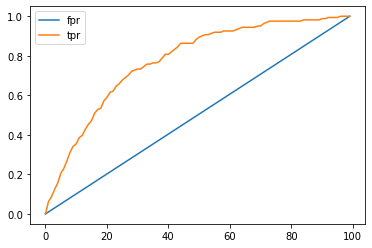

In [16]:
#Plot of ROC Curve
lr_curve_df.plot.line()

In [17]:
#AUC data
lr_auc_df

,fold,auc,model
0,0,0.772954,logistic regression
1,1,0.831462,logistic regression
2,2,0.762849,logistic regression
3,3,0.830838,logistic regression
4,4,0.700724,logistic regression
5,5,0.805639,logistic regression
6,6,0.755412,logistic regression
7,7,0.734250,logistic regression
8,8,0.796250,logistic regression
9,9,0.754000,logistic regression


In [18]:
#average AUC
lr_auc_df["auc"].mean()

0.7744377832570153